In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline


spark = SparkSession.builder \
    .appName("KMeansTraining") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session is ready for Machine Learning!")

Spark Session is ready for Machine Learning!


In [3]:
# Đường dẫn đến file parquet đã xử lý
processed_path = "../data/processed/user_features.parquet"

# Đọc dữ liệu
user_features_df = spark.read.parquet(processed_path)

print("User features data (input for model) loaded successfully:")
user_features_df.show(5)

User features data (input for model) loaded successfully:
+--------------+--------------+------------+-------------------+
|          uuid|total_ads_seen|total_clicks| click_through_rate|
+--------------+--------------+------------+-------------------+
|10000a34905274|            12|           2|0.16666665277777895|
|10000a91d9899d|             4|           1|0.24999993750001562|
|10000e5327e96b|             6|           2|0.33333327777778704|
|10001d737d2983|             6|           1|0.16666663888889352|
|10001f505856f1|             4|           1|0.24999993750001562|
+--------------+--------------+------------+-------------------+
only showing top 5 rows



In [4]:
# 1. Định nghĩa các cột đặc trưng
feature_columns = ["total_ads_seen", "total_clicks", "click_through_rate"]

# 2. Tạo các bước xử lý: Assembler và Scaler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")
scaler = StandardScaler(inputCol="features_raw", outputCol="features")

# 3. Tạo Pipeline để thực hiện tuần tự
pipeline = Pipeline(stages=[assembler, scaler])

# 4. Áp dụng pipeline vào dữ liệu
scaler_model = pipeline.fit(user_features_df)
data_for_clustering = scaler_model.transform(user_features_df)

print("Data after being vectorized and scaled:")
data_for_clustering.select("features").show(5, truncate=False)

Data after being vectorized and scaled:
+----------------------------------------------------------+
|features                                                  |
+----------------------------------------------------------+
|[3.4347458066783174,3.908564270678957,1.9273098809801539] |
|[1.1449152688927724,1.9542821353394786,2.8909643396428804]|
|[1.7173729033391587,3.908564270678957,3.8546194407420473] |
|[1.7173729033391587,1.9542821353394786,1.9273097203710237]|
|[1.1449152688927724,1.9542821353394786,2.8909643396428804]|
+----------------------------------------------------------+
only showing top 5 rows



Calculating clustering costs for different values of k...
Cost for k=2: 33590804.37988536
Cost for k=3: 20629669.881389856
Cost for k=4: 15515427.097524835
Cost for k=5: 11157747.881746598
Cost for k=6: 6769794.52707367
Cost for k=7: 5868346.057321475
Cost for k=8: 4937316.594079908
Cost for k=9: 4296634.685018333
Cost for k=10: 2624614.4075352144


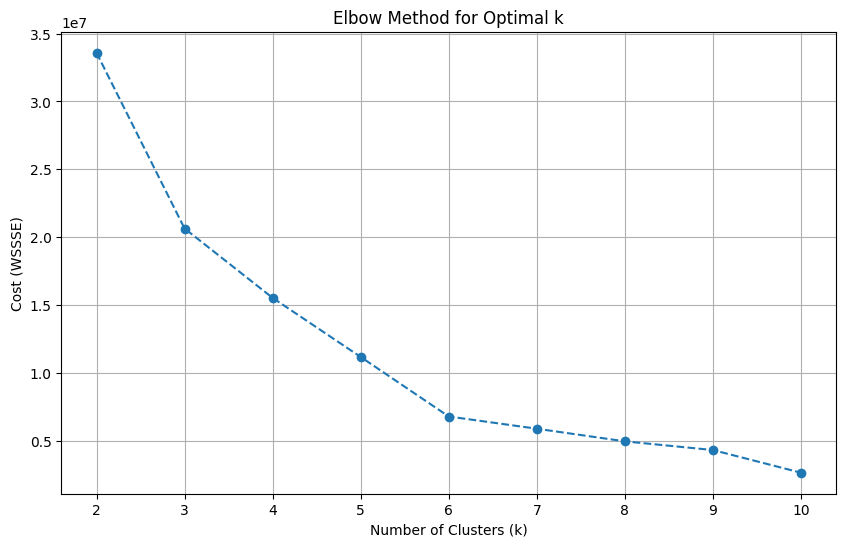

In [5]:
k_values = range(2, 11)
costs = []

print("Calculating clustering costs for different values of k...")
for k in k_values:
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    model = kmeans.fit(data_for_clustering)
    cost = model.summary.trainingCost 
    costs.append(cost)
    print(f"Cost for k={k}: {cost}")

# Vẽ biểu đồ
elbow_df = pd.DataFrame({'k': k_values, 'cost': costs})
plt.figure(figsize=(10, 6))
plt.plot(elbow_df['k'], elbow_df['cost'], marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (WSSSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [6]:
# THAY SỐ 4 BẰNG SỐ K BẠN CHỌN TỪ BIỂU ĐỒ
FINAL_K = 4

print(f"Training final model with k={FINAL_K}...")
kmeans = KMeans(featuresCol='features', k=FINAL_K, seed=42)
final_model = kmeans.fit(data_for_clustering)

# Gán nhãn cụm cho mỗi người dùng
predictions = final_model.transform(data_for_clustering)

print("\nClustering results:")
predictions.select("uuid", "total_clicks", "click_through_rate", "prediction").show(20)

Training final model with k=4...

Clustering results:
+--------------+------------+-------------------+----------+
|          uuid|total_clicks| click_through_rate|prediction|
+--------------+------------+-------------------+----------+
|10000a34905274|           2|0.16666665277777895|         3|
|10000a91d9899d|           1|0.24999993750001562|         0|
|10000e5327e96b|           2|0.33333327777778704|         3|
|10001d737d2983|           1|0.16666663888889352|         0|
|10001f505856f1|           1|0.24999993750001562|         0|
|1000206f97aeae|           1|0.24999993750001562|         0|
|10003257b458c4|           1|  0.499999750000125|         1|
|100039c3f24f11|           1|0.16666663888889352|         0|
|1000455ca42b79|           1|0.24999993750001562|         0|
|100058f344f2d5|           1|0.24999993750001562|         0|
|10006f16074afd|           1|  0.199999960000008|         0|
|1000797641694e|           1|0.16666663888889352|         0|
|1000802080dd81|           1|0.

In [7]:
# 1. Phân tích đặc điểm các cụm
print("Analyzing the characteristics of each cluster...")
segment_summary = predictions.groupBy("prediction").agg(
    avg("total_ads_seen").alias("avg_ads_seen"),
    avg("total_clicks").alias("avg_clicks"),
    avg("click_through_rate").alias("avg_ctr")
).orderBy("prediction")

print("Summary of each customer segment:")
segment_summary.show()

# 2. LƯU MÔ HÌNH
model_path = "../models/kmeans_model"
final_model.write().overwrite().save(model_path)
print(f"\nK-Means model saved successfully to: {model_path}")

# 3. LƯU KẾT QUẢ PHÂN CỤM
final_segmentation_df = predictions.select("uuid", "prediction")
segmentation_path = "../data/processed/customer_segments.parquet"
final_segmentation_df.write.mode("overwrite").parquet(segmentation_path)
print(f"Customer segmentation results saved to: {segmentation_path}")

# 4. LƯU BẢNG TÓM TẮT
summary_path = "../data/processed/segment_summary.csv"
segment_summary.toPandas().to_csv(summary_path, index=False)
print(f"Segment summary saved to: {summary_path}")

Analyzing the characteristics of each cluster...
Summary of each customer segment:
+----------+------------------+------------------+-------------------+
|prediction|      avg_ads_seen|        avg_clicks|            avg_ctr|
+----------+------------------+------------------+-------------------+
|         0| 5.291559104966816|               1.0|0.20833722540563282|
|         1| 2.124326721913788|1.0560770601237517| 0.4987824969948652|
|         2|26.317573040612256| 4.520913636109714|0.18172743003875821|
|         3|11.301972832846435|2.1576489499856257|0.20578416141739303|
+----------+------------------+------------------+-------------------+


K-Means model saved successfully to: ../models/kmeans_model
Customer segmentation results saved to: ../data/processed/customer_segments.parquet
Segment summary saved to: ../data/processed/segment_summary.csv
